In [1]:
#import dependencies

import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers, optimizers
import numpy as np
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
# download and split the data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print("training data = ", x_train.shape)
print("testing data = ", x_test.shape)

('training data = ', (50000, 32, 32, 3))
('testing data = ', (10000, 32, 32, 3))


In [3]:
# Normalize the data to speed up training
mean = np.mean(x_train)
std = np.std(x_train)
x_train = (x_train-mean)/(std+1e-7)
x_test = (x_test-mean)/(std+1e-7)

# let's look at the normalized values of a sample image
x_train[0]

array([[[-0.96192449, -0.91515917, -0.8995707 ],
        [-1.21133983, -1.1645745 , -1.18016291],
        [-1.10222065, -1.13339758, -1.21133983],
        ..., 
        [ 0.58133286,  0.17603296, -0.19809005],
        [ 0.48780212,  0.06691375, -0.29162079],
        [ 0.4254483 ,  0.05132529, -0.27603233]],

       [[-1.63222826, -1.56987441, -1.56987441],
        [-1.88164353, -1.88164353, -1.88164353],
        [-1.60105133, -1.75693595, -1.88164353],
        ..., 
        [ 0.03573683, -0.5098592 , -1.0242784 ],
        [-0.026617  , -0.58780152, -1.10222065],
        [ 0.02014837, -0.52544767, -0.99310142]],

       [[-1.49193215, -1.50752056, -1.554286  ],
        [-1.63222826, -1.77252436, -1.88164353],
        [-1.11780906, -1.46075523, -1.75693595],
        ..., 
        [-0.04220546, -0.57221305, -1.10222065],
        [-0.01102854, -0.57221305, -1.10222065],
        [-0.18250158, -0.74368608, -1.22692835]],

       ..., 
       [[ 1.3607558 ,  0.76839441, -0.38515157],
        

In [4]:
# one-hot encode the labels in train and test datasets
# we use “to_categorical” function in keras 

num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

# let's display one of the one-hot encoded labels
y_train[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.])

In [5]:
# build the model

# number of hidden units variable 
# we are declaring this variable here and use it in our CONV layers to make it easier to update from one place
base_hidden_units = 32

# l2 regularization hyperparameter
weight_decay = 1e-4 

# instantiate an empty sequential model 
model = Sequential()

# CONV1
# notice that we defined the input_shape here because this is the first CONV layer. 
# we don’t need to do that for the remaining layers
model.add(Conv2D(base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV2
model.add(Conv2D(base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# CONV3
model.add(Conv2D(2*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV4
model.add(Conv2D(2*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# CONV5
model.add(Conv2D(4*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV6
model.add(Conv2D(4*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# FC7
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

# print model summary
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
__________

In [6]:
# data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )

# compute the data augmentation on the training set
datagen.fit(x_train)

In [7]:
# training
batch_size = 64
epochs=125

from keras.callbacks import ModelCheckpoint   

checkpointer = ModelCheckpoint(filepath='model.125epochs.hdf5', verbose=1, save_best_only=True)

# you can try any of these optimizers by uncommenting the line
# optimizer = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
# optimizer = keras.optimizers.adam(lr=0.0005,decay=1e-6)

optimizer = keras.optimizers.rmsprop(lr=0.0003,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), callbacks=[checkpointer],
                steps_per_epoch=x_train.shape[0] // batch_size, epochs=epochs,verbose=2,
                validation_data=(x_test,y_test))


Epoch 1/125
Epoch 00000: val_loss improved from inf to 1.39004, saving model to model.125epochs.hdf5
59s - loss: 2.1036 - acc: 0.3702 - val_loss: 1.3900 - val_acc: 0.5341
Epoch 2/125
Epoch 00001: val_loss improved from 1.39004 to 1.14078, saving model to model.125epochs.hdf5
57s - loss: 1.5178 - acc: 0.5076 - val_loss: 1.1408 - val_acc: 0.6219
Epoch 3/125
Epoch 00002: val_loss improved from 1.14078 to 1.04460, saving model to model.125epochs.hdf5
57s - loss: 1.3140 - acc: 0.5757 - val_loss: 1.0446 - val_acc: 0.6508
Epoch 4/125
Epoch 00003: val_loss improved from 1.04460 to 0.88671, saving model to model.125epochs.hdf5
57s - loss: 1.1831 - acc: 0.6211 - val_loss: 0.8867 - val_acc: 0.7078
Epoch 5/125
Epoch 00004: val_loss did not improve
57s - loss: 1.0866 - acc: 0.6464 - val_loss: 0.9728 - val_acc: 0.7010
Epoch 6/125
Epoch 00005: val_loss improved from 0.88671 to 0.81255, saving model to model.125epochs.hdf5
57s - loss: 1.0149 - acc: 0.6708 - val_loss: 0.8125 - val_acc: 0.7407
Epoch 7/1

Epoch 00054: val_loss did not improve
64s - loss: 0.5254 - acc: 0.8432 - val_loss: 0.4500 - val_acc: 0.8764
Epoch 56/125
Epoch 00055: val_loss improved from 0.43660 to 0.43647, saving model to model.125epochs.hdf5
64s - loss: 0.5236 - acc: 0.8447 - val_loss: 0.4365 - val_acc: 0.8763
Epoch 57/125
Epoch 00056: val_loss improved from 0.43647 to 0.43199, saving model to model.125epochs.hdf5
65s - loss: 0.5226 - acc: 0.8439 - val_loss: 0.4320 - val_acc: 0.8788
Epoch 58/125
Epoch 00057: val_loss did not improve
64s - loss: 0.5174 - acc: 0.8451 - val_loss: 0.4376 - val_acc: 0.8779
Epoch 59/125
Epoch 00058: val_loss did not improve
65s - loss: 0.5152 - acc: 0.8471 - val_loss: 0.4573 - val_acc: 0.8705
Epoch 60/125
Epoch 00059: val_loss improved from 0.43199 to 0.42605, saving model to model.125epochs.hdf5
64s - loss: 0.5153 - acc: 0.8464 - val_loss: 0.4260 - val_acc: 0.8809
Epoch 61/125
Epoch 00060: val_loss did not improve
64s - loss: 0.5125 - acc: 0.8488 - val_loss: 0.4400 - val_acc: 0.8772
E

Epoch 00117: val_loss did not improve
31s - loss: 0.4594 - acc: 0.8685 - val_loss: 0.4139 - val_acc: 0.8894
Epoch 119/125
Epoch 00118: val_loss did not improve
30s - loss: 0.4487 - acc: 0.8712 - val_loss: 0.4165 - val_acc: 0.8915
Epoch 120/125
Epoch 00119: val_loss did not improve
31s - loss: 0.4482 - acc: 0.8722 - val_loss: 0.4146 - val_acc: 0.8896
Epoch 121/125
Epoch 00120: val_loss did not improve
30s - loss: 0.4471 - acc: 0.8741 - val_loss: 0.4124 - val_acc: 0.8886
Epoch 122/125
Epoch 00121: val_loss improved from 0.40342 to 0.40327, saving model to model.125epochs.hdf5
31s - loss: 0.4510 - acc: 0.8719 - val_loss: 0.4033 - val_acc: 0.8934
Epoch 123/125
Epoch 00122: val_loss improved from 0.40327 to 0.40112, saving model to model.125epochs.hdf5
30s - loss: 0.4497 - acc: 0.8735 - val_loss: 0.4011 - val_acc: 0.8959
Epoch 124/125
Epoch 00123: val_loss did not improve
30s - loss: 0.4473 - acc: 0.8725 - val_loss: 0.4162 - val_acc: 0.8894
Epoch 125/125
Epoch 00124: val_loss did not improv

In [8]:
# evaluating the model
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

 9728/10000 [============================>.] - ETA: 0s
Test result: 89.590 loss: 0.403


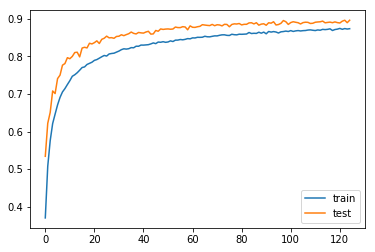

In [9]:
# plot learning curves of model accuracy
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()